In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ah-tickets/tickets.csv
/kaggle/input/model1/variables.index
/kaggle/input/model1/fingerprint.pb
/kaggle/input/model1/saved_model.pb
/kaggle/input/model1/variables.data-00000-of-00001
/kaggle/input/model1/keras_metadata.pb


## Table of Contents
- [1 - Helper Class](#1)
- [2 - GAN Using Sigmoid](#2)
    - [2.1 - Model class](#2-1)
    - [2.2 - Training](#2-2)
    - [2.3 - Distribution and K.L divergence](#2-3)
    - [2.4 - Cosine Similarity score](#2-4)
- [3 - GAN Using Softmax](#3)
    - [3.1 - Model class](#3-1)
    - [3.2 - Training](#3-2)
    - [3.3 - Distribution and K.L divergence](#3-3)
    - [3.4 - Cosine Similarity score](#3-4)
- [4 - VAE Using Sigmoid](#4)
    - [4.1 - Model class](#4-1)
    - [4.2 - Distribution and K.L divergence](#4-2)
    - [4.3 - Cosine Similarity score](#4-3)
- [5 - VAE Using Softmax](#5)
    - [5.1 - Model class](#5-1)
    - [5.2 - Training](#5-2)
    - [5.3 - Distribution and K.L divergence](#5-3)
    - [5.4 - Cosine Similarity score](#5-4)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv('/kaggle/input/ah-tickets/tickets.csv')

In [4]:
data

,task_type,creation_date,view_date,action_date,customer_satisfaction,customer_problem_resolved,user_actioned,user_team
0,email,2021-01-02 02:49:00.000000000,2021-01-02 08:34:00.000000000,2021-01-02 08:53:00.000000000,5,True,13b968,green
1,email,2021-01-02 03:33:00.000000000,2021-01-02 08:59:00.000000000,2021-01-02 09:35:00.000000000,3,True,13b968,green
2,web_form,2021-01-02 08:43:00.000000000,2021-01-02 09:40:00.000000000,2021-01-02 10:05:00.000000000,3,True,13b968,green
3,web_form,2021-01-02 09:12:00.000000000,2021-01-02 10:11:00.000000000,2021-01-02 10:47:00.000000000,2,False,13b968,green
4,email,2021-01-02 10:21:00.000000000,2021-01-02 10:52:00.000000000,2021-01-02 11:26:00.000000000,5,True,13b968,green
...,...,...,...,...,...,...,...,...
306414,live_chat,2021-12-27 14:38:32.373741188,2021-12-27 14:40:32.373741188,2021-12-27 15:06:32.373741188,3,False,24503c,orange
306415,email,2021-07-08 11:58:00.000000000,2021-12-27 15:13:32.373741188,2021-12-27 15:40:32.373741188,1,False,24503c,orange
306416,web_form,2021-08-18 04:43:00.000000000,2021-12-27 15:42:32.373741188,2021-12-27 16:14:32.373741188,1,False,24503c,orange
306417,live_chat,2021-12-27 16:15:32.373741188,2021-12-27 16:16:32.373741188,2021-12-27 16:31:32.373741188,1,False,24503c,orange


In [5]:
def compute_kl_divergence(original_data, synthesized_data):
    kl_divergence = 0.0
    all_values = set(original_data.values.flatten()) | set(synthesized_data.values.flatten())

    for column in original_data.columns:
        # Convert the NumPy arrays to tuples
        original_column_values = tuple(original_data[column].values)
        synthesized_column_values = tuple(synthesized_data[column].values)

        # Compute probability distributions for each column
        p = pd.Series(original_column_values).value_counts(normalize=True).reindex(all_values, fill_value=0)
        q = pd.Series(synthesized_column_values).value_counts(normalize=True).reindex(all_values, fill_value=0)

        # Add a small epsilon to avoid division by zero
        epsilon = 1e-10
        p = p + epsilon
        q = q + epsilon

        # Calculate KL divergence for the current column
        kl_divergence += entropy(p, q)

    # Aggregate KL divergence across all columns
    return kl_divergence

<a name='1'></a>
## 1- Helper

In [6]:
class Helper():
  def __init__(self,data):
    self.data = data
  def plot_data(self,save_path):
    num_rows = 2
    num_cols = 9
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 8))
    
    features = self.data.columns  # Assuming features are column names
    for i, feature in enumerate(features):
        row_index = i // num_cols
        col_index = i % num_cols

        unique_values = self.data[feature].unique()
        value_counts = self.data[feature].value_counts()

        axes[row_index, col_index].bar(unique_values, value_counts)
        axes[row_index, col_index].set_title(feature)
    if save_path:
        plt.savefig(save_path)

    plt.show()
    return features
  def drop_date(self):
    columns_to_drop = ['creation_date', 'view_date','action_date']
    self.data = self.data.drop(columns=columns_to_drop)
  def replace_values_to_number(self,column_name):
    list_of_values = self.data[column_name].unique()
    d = dict(zip(list_of_values, range(len(list_of_values))))
    for i in range(len(list_of_values)):
        self.data[column_name] = self.data[column_name].replace(list_of_values[i], i)
    return d
  def replace_values_to_number_with_dict(self,column_name, dic):
      list_of_values = self.data[column_name].unique()
      for i in range(len(list_of_values)):
          self.data[column_name] = self.data[column_name].replace(list_of_values[i], list(dic.keys())[i])
  def replace_dates(self):
    dates = ['creation','view','action']
    for date in dates:
        self.data[f'{date}_date'] = pd.to_datetime(self.data[f'{date}_date'])
        self.data[f'{date}_month'] = self.data[f'{date}_date'].dt.month
        self.data[f'{date}_day'] = self.data[f'{date}_date'].dt.day
        self.data[f'{date}_hour'] = self.data[f'{date}_date'].dt.hour
        self.data[f'{date}_minute'] = self.data[f'{date}_date'].dt.minute
  def convert_all_data_sig(self):
    features = self.data.head(0)
    thre = []
    for feature in features:
      thre.append(1/self.data[feature].max())
      self.data[feature]= self.data[feature]/self.data[feature].max()
    return thre
  def on_hot_encode(self):
    features = self.data.head(0)
    encoded_features=[]
    for feature in features:
      unique_values = data[feature].unique()
      encoded = np.eye(len(unique_values))[np.where(data[feature].values[:, None] == unique_values)[1]]
      encoded_features.append(encoded)
    return encoded_features

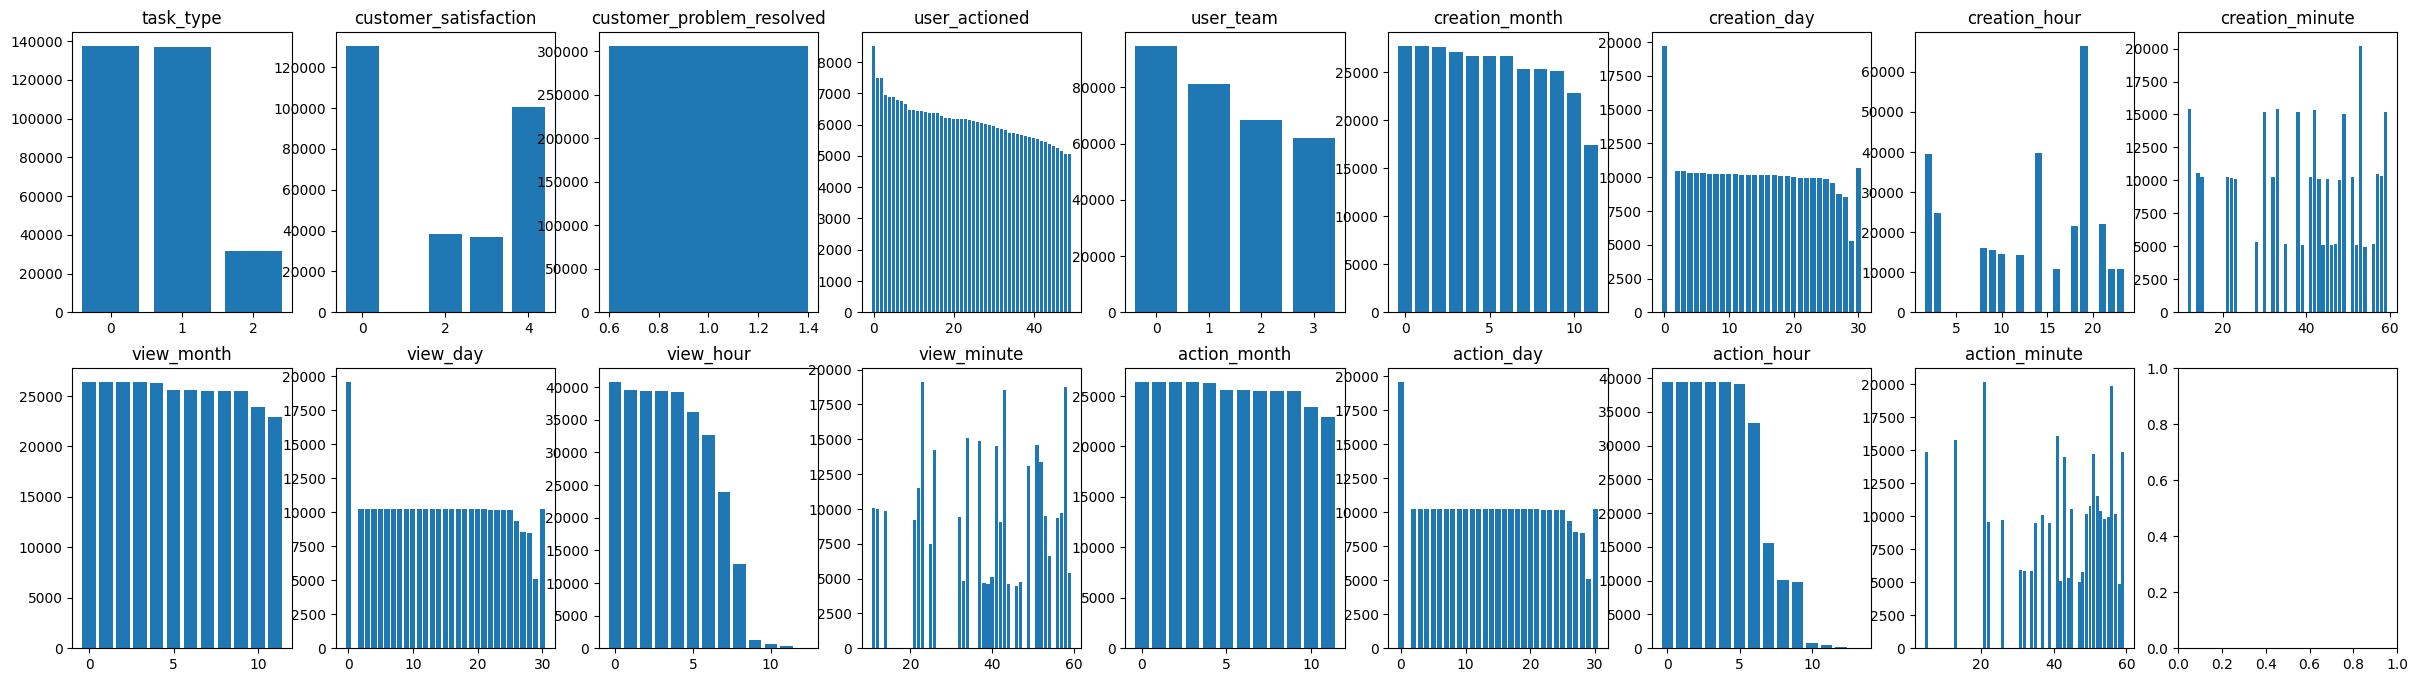

In [7]:
helper1 = Helper(data)
helper1.replace_dates()
helper1.drop_date()
features = helper1.data.head(0)
dics = []
for feature in features:
    dics.append(helper1.replace_values_to_number(feature))
data_org = helper1.data.copy()
cols = helper1.plot_data('/kaggle/working/real_data.png')
th_out = helper1.convert_all_data_sig()
Sigmoid_data = helper1.data

In [8]:
Sigmoid_data = tf.Variable(Sigmoid_data)

<a name='2'></a>
## 1- GAN_sigmoid

<a name='2-1'></a>
**Class of GAN_sigmoid**

In [9]:
class GANS_Sigmoid():
  def __init__(self,data,noise_size,num_epochs,batch_size):
    self.data = data
    self.num_samples = self.data.shape[0]
    self.num_features = self.data.shape[1]
    self.noise_size = noise_size
    self.gen = self.generator()
    self.disc = self.discriminator()
    self.num_epochs = num_epochs
    self.batch_size = batch_size
  def Fit(self):
    disc_losses=[]
    gen_losses=[]
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)
    gen_vars = self.gen .trainable_variables
    disc_vars = self.disc.trainable_variables
    generator_optimizer.build(gen_vars)
    discriminator_optimizer.build(disc_vars)
    # Training loop
    num_epochs = self.num_epochs
    batch_size = self.batch_size
    for epoch in range(num_epochs):
        for _ in range(self.num_samples // batch_size):
            # Train the discriminator
            with tf.GradientTape() as tape:
                noise = tf.random.normal((batch_size, self.noise_size))
                fake_data = self.gen(noise)
                real_output = self.disc(self.data[_*batch_size:(_+1)*batch_size])
                fake_output = self.disc(fake_data)
                loss = self.discriminator_loss(real_output, fake_output)
                # # Build the optimizer with the model's variables
            gradients = tape.gradient(loss, self.disc.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients, disc_vars))
            # Train the generator
            with tf.GradientTape() as tape:
                fake_data = self.gen(tf.random.normal((batch_size, self.noise_size)))
                fake_output = self.disc(fake_data)
                loss = self.generator_loss(fake_output)
            gradients = tape.gradient(loss, self.gen.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients, self.gen.trainable_variables))
        disc_losses.append(np.mean(self.discriminator_loss(real_output, fake_output)))
        gen_losses.append(np.mean(self.generator_loss(fake_output)))
        print(f"Epoch {epoch}: Discriminator Loss = {np.mean(self.discriminator_loss(real_output, fake_output))}, Generator Loss = {np.mean(self.generator_loss(fake_output))}")
    return disc_losses,gen_losses
# Define the generator and discriminator networks
  def generator(self):
      model = tf.keras.Sequential([
          tf.keras.layers.Dense(128, activation='relu', input_shape=(self.noise_size,)),
          tf.keras.layers.Dense(256, activation='LeakyReLU'),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dense(1024, activation='LeakyReLU'),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dense(256, activation='LeakyReLU'),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(self.num_features,activation='sigmoid')
      ])
      return model

  def discriminator(self):
      model = tf.keras.Sequential([
          tf.keras.layers.Dense(64, activation='relu', input_shape=(self.num_features,)),
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dense(512, activation='LeakyReLU'),
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
      ])
      return model

# Define the loss function for the discriminator
  def discriminator_loss(self,real_output, fake_output):
      real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
      fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
      return real_loss + fake_loss

# Define the loss function for the generator
  def generator_loss(self,fake_output):
      return tf.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
  def Predict(self,num_samples):
    output = self.gen(tf.random.normal((num_samples, self.noise_size)))
    final = np.zeros((num_samples,self.num_features))
    for i in range(self.num_features):
      final[:,i] = output[:,i]/th_out[i]
    final = np.round(final).astype(int)
    return final
  def plot_dist(self, num_samples, feature_names, save_path=None):
    final = self.Predict(num_samples)
    
    # Calculate the number of rows and columns for the subplots
    num_rows = 2
    num_cols = 9
    
    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 8))
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten()
    
    for i in range(min(self.num_features, num_rows * num_cols)):
        unique_values, value_counts = np.unique(final[:, i], return_counts=True)
        axes[i].bar(unique_values, value_counts)
        axes[i].set_title(f'{feature_names[i]}')  # Use feature names as titles for each subplot

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()


<a name='2-2'></a>
**Training**

In [10]:
G1 = GANS_Sigmoid(Sigmoid_data,512,30,2048)
disc,gen = G1.Fit()

Epoch 0: Discriminator Loss = 0.30247771739959717, Generator Loss = 3.1459522247314453
Epoch 1: Discriminator Loss = 3.8363983631134033, Generator Loss = 1.797692060470581
Epoch 2: Discriminator Loss = 0.15397828817367554, Generator Loss = 2.040315628051758
Epoch 3: Discriminator Loss = 0.3664954900741577, Generator Loss = 1.9102592468261719
Epoch 4: Discriminator Loss = 0.13649024069309235, Generator Loss = 3.244981288909912
Epoch 5: Discriminator Loss = 2.1174464225769043, Generator Loss = 0.3995448350906372
Epoch 6: Discriminator Loss = 1.196152687072754, Generator Loss = 0.8509274125099182
Epoch 7: Discriminator Loss = 1.2734262943267822, Generator Loss = 0.7957215309143066
Epoch 8: Discriminator Loss = 0.7127820253372192, Generator Loss = 1.1806020736694336
Epoch 9: Discriminator Loss = 0.36835771799087524, Generator Loss = 1.8947027921676636
Epoch 10: Discriminator Loss = 0.12192420661449432, Generator Loss = 2.339543581008911
Epoch 11: Discriminator Loss = 0.7505530714988708, Ge

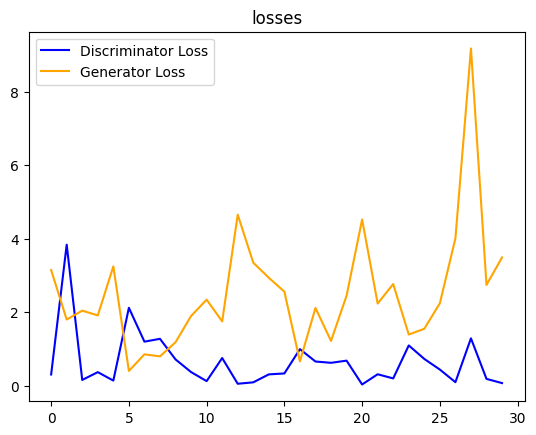

In [11]:
plt.title('losses')
plt.plot(range(len(disc)),disc,label='Discriminator Loss',color='blue')
plt.plot(range(len(gen)),gen,label='Generator Loss',color='orange')
plt.legend()
plt.show()

<a name='2-3'></a>
**Data plot**



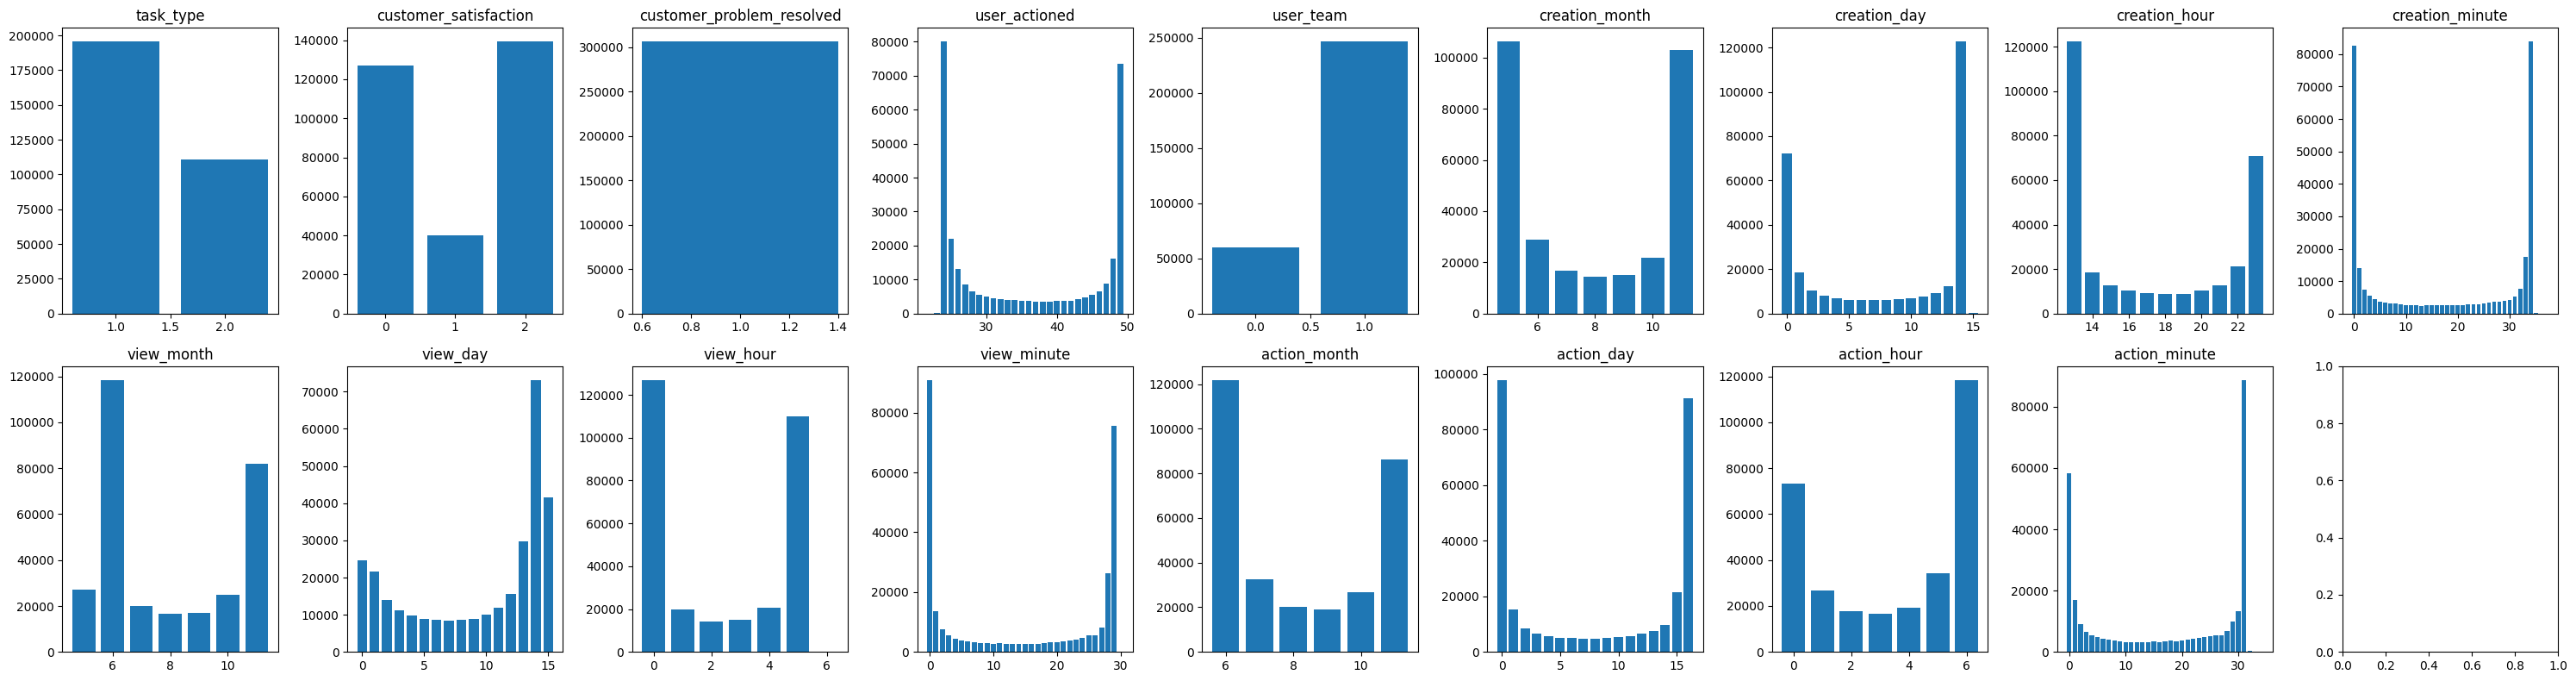

KL Divergence: 159.2944591374134


In [12]:
G1.plot_dist(306419,cols,'/kaggle/working/GAN_sigmoid.png')
GAN_sigmoid = G1.Predict(306419)
GAN_S_df = pd.DataFrame(data=GAN_sigmoid, columns=cols)
G1.gen.save('/kaggle/working/GAN_sigmoid.h5')
## KL
kl_divergence = compute_kl_divergence(data_org, GAN_S_df)
print(f"KL Divergence: {kl_divergence}")
## Cosine similarity

<a name='2-4'></a>
**Cosine similarity**

In [13]:
batch_size = 1000  # Adjust this based on your available memory
num_samples = data_org.shape[0]

# Initialize an empty list to store batch similarity scores
batch_similarity_scores = []

for i in range(0, num_samples, batch_size):
    end_idx = min(i + batch_size, num_samples)
    batch_original = data_org[i:end_idx]
    batch_synthesized = GAN_S_df[i:end_idx]

    # Calculate cosine similarity for the batch
    batch_cosine_sim = cosine_similarity(batch_original, batch_synthesized)

    # Append the mean similarity score for the batch to the list
    batch_similarity_scores.append(np.mean(batch_cosine_sim))

# Calculate the overall mean cosine similarity score
mean_cosine_similarity = np.mean(batch_similarity_scores)

print(f"Mean Cosine Similarity Score: {mean_cosine_similarity}")


Mean Cosine Similarity Score: 0.6850409324564606


In [14]:
helper2 = Helper(data)
helper2.replace_dates()
helper2.drop_date()
features = helper2.data.head(0)
dics = []
for feature in features:
    dics.append(helper2.replace_values_to_number(feature))
encoded = helper2.on_hot_encode()

<a name='3'></a>
## 2- GAN_softmax

<a name='3-1'></a>
**Class of GAN_softmax**

In [15]:
class GANS_Soft():
  def __init__(self,data,noise_size,num_epochs,batch_size):
    self.data = data
    # Generate some random tabular data for demonstration purposes
    self.num_samples = self.data.shape[0]
    self.num_features = self.data.shape[1]
    self.noise_size = noise_size
    self.gen = self.generator()
    self.disc = self.discriminator()
    self.num_epochs = num_epochs
    self.batch_size = batch_size
  def Fit(self):
    disc_losses=[]
    gen_losses=[]
    generator_optimizer = tf.keras.optimizers.Adam(1e-1)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-1)
    gen_vars = self.gen .trainable_variables
    disc_vars = self.disc.trainable_variables
    generator_optimizer.build(gen_vars)
    discriminator_optimizer.build(disc_vars)
    # Training loop
    num_epochs = self.num_epochs
    batch_size = self.batch_size
    for epoch in range(num_epochs):
        for _ in range(self.num_samples // batch_size):
            # Train the discriminator
            with tf.GradientTape() as tape:
                noise = tf.random.normal((batch_size, self.noise_size))
                fake_data = self.gen(noise)
                real_output = self.disc(data[_*batch_size:(_+1)*batch_size])
                fake_output = self.disc(fake_data)
                loss = self.discriminator_loss(real_output, fake_output)


                # # Build the optimizer with the model's variables

            gradients = tape.gradient(loss, self.disc.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients, disc_vars))


            # Train the generator
            with tf.GradientTape() as tape:
                fake_data = self.gen(tf.random.normal((batch_size, self.noise_size)))
                fake_output = self.disc(fake_data)
                loss = self.generator_loss(fake_output)
            gradients = tape.gradient(loss, self.gen.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients, self.gen.trainable_variables))
        disc_losses.append(np.mean(self.discriminator_loss(real_output, fake_output)))
        gen_losses.append(np.mean(self.generator_loss(fake_output)))
        print(f"Epoch {epoch}: Discriminator Loss = {np.mean(self.discriminator_loss(real_output, fake_output))}, Generator Loss = {np.mean(self.generator_loss(fake_output))}")
    return disc_losses,gen_losses
# Define the generator and discriminator networks
  def generator(self):
      model = tf.keras.Sequential([
          tf.keras.layers.Dense(128, activation='relu', input_shape=(self.noise_size,)),
          tf.keras.layers.Dense(256, activation='LeakyReLU'),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dense(1024, activation='LeakyReLU'),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dense(256, activation='LeakyReLU'),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(self.num_features,activation='softmax')
      ])
      return model

  def discriminator(self):
      model = tf.keras.Sequential([
          tf.keras.layers.Dense(64, activation='relu', input_shape=(self.num_features,)),
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
      ])
      return model

# Define the loss function for the discriminator
  def discriminator_loss(self,real_output, fake_output):
      real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
      fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
      return real_loss + fake_loss

# Define the loss function for the generator
  def generator_loss(self,fake_output):
      return tf.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
  def Predict(self,num_samples):
    noise = tf.random.normal((num_samples, self.noise_size))
    generated_samples = self.gen(noise)

    # Convert one-hot encoded outputs to predicted classes
    predicted_classes = tf.argmax(generated_samples, axis=1)
    output_column_name = 'output'  # Replace with your desired column name
    generated_df = pd.DataFrame({output_column_name: predicted_classes.numpy()})

    return generated_df
    
    
  def plot_dist(self, num_samples, feature_names, save_path=None):
    final = self.Predict(num_samples)
    
    # Calculate the number of rows and columns for the subplots
    num_rows = 2
    num_cols = 9
    
    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 8))
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten()
    
    for i in range(min(self.num_features, num_rows * num_cols)):
        unique_values, value_counts = np.unique(final[:,i], return_counts=True)
        axes[i].bar(unique_values, value_counts)
        axes[i].set_title(f'{feature_names[i]}')  # Use feature names as titles for each subplot

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()


<a name='3-2'></a>
**Training**

In [16]:
result_dfs = []  # List to collect DataFrames

for i in range(len(encoded)):
    data = encoded[i]  # Assuming encoded[i] is a NumPy array or TensorFlow tensor
    G2 = GANS_Soft(data, 1024, 10, 2048)
    disc, gen = G2.Fit()
    G2.gen.save(f'/kaggle/working/GAN_softmax_{i}.h5')
    
    # Plot and save the distribution plot if needed
    # G2.plot_dist(306419, f'/kaggle/working/syn_data_{i}.png')
    
    synthetic_data = G2.Predict(306419)
    
    # Append synthetic data DataFrame to the list
    result_dfs.append(synthetic_data)

# Concatenate all DataFrames in the list
GAN_M_df = pd.concat(result_dfs, axis=1)

# Reset the index of the final DataFrame
GAN_M_df.reset_index(drop=True, inplace=True)
GAN_M_df.columns = cols

Epoch 0: Discriminator Loss = 1.3860466480255127, Generator Loss = 0.6932096481323242
Epoch 1: Discriminator Loss = 1.4609787464141846, Generator Loss = 0.6599932909011841
Epoch 2: Discriminator Loss = 1.386306881904602, Generator Loss = 0.6931037902832031
Epoch 3: Discriminator Loss = 1.3862946033477783, Generator Loss = 0.6931473016738892
Epoch 4: Discriminator Loss = 1.3862940073013306, Generator Loss = 0.6931473612785339
Epoch 5: Discriminator Loss = 1.3862947225570679, Generator Loss = 0.6931470036506653
Epoch 6: Discriminator Loss = 1.3862946033477783, Generator Loss = 0.6931470036506653
Epoch 7: Discriminator Loss = 1.3862946033477783, Generator Loss = 0.6931473016738892
Epoch 8: Discriminator Loss = 1.3862940073013306, Generator Loss = 0.6931475400924683
Epoch 9: Discriminator Loss = 1.3862940073013306, Generator Loss = 0.6931473612785339
Epoch 0: Discriminator Loss = 1.2178361415863037, Generator Loss = 0.779293954372406
Epoch 1: Discriminator Loss = 1.2194592952728271, Genera

<a name='3-3'></a>
**Data plot**


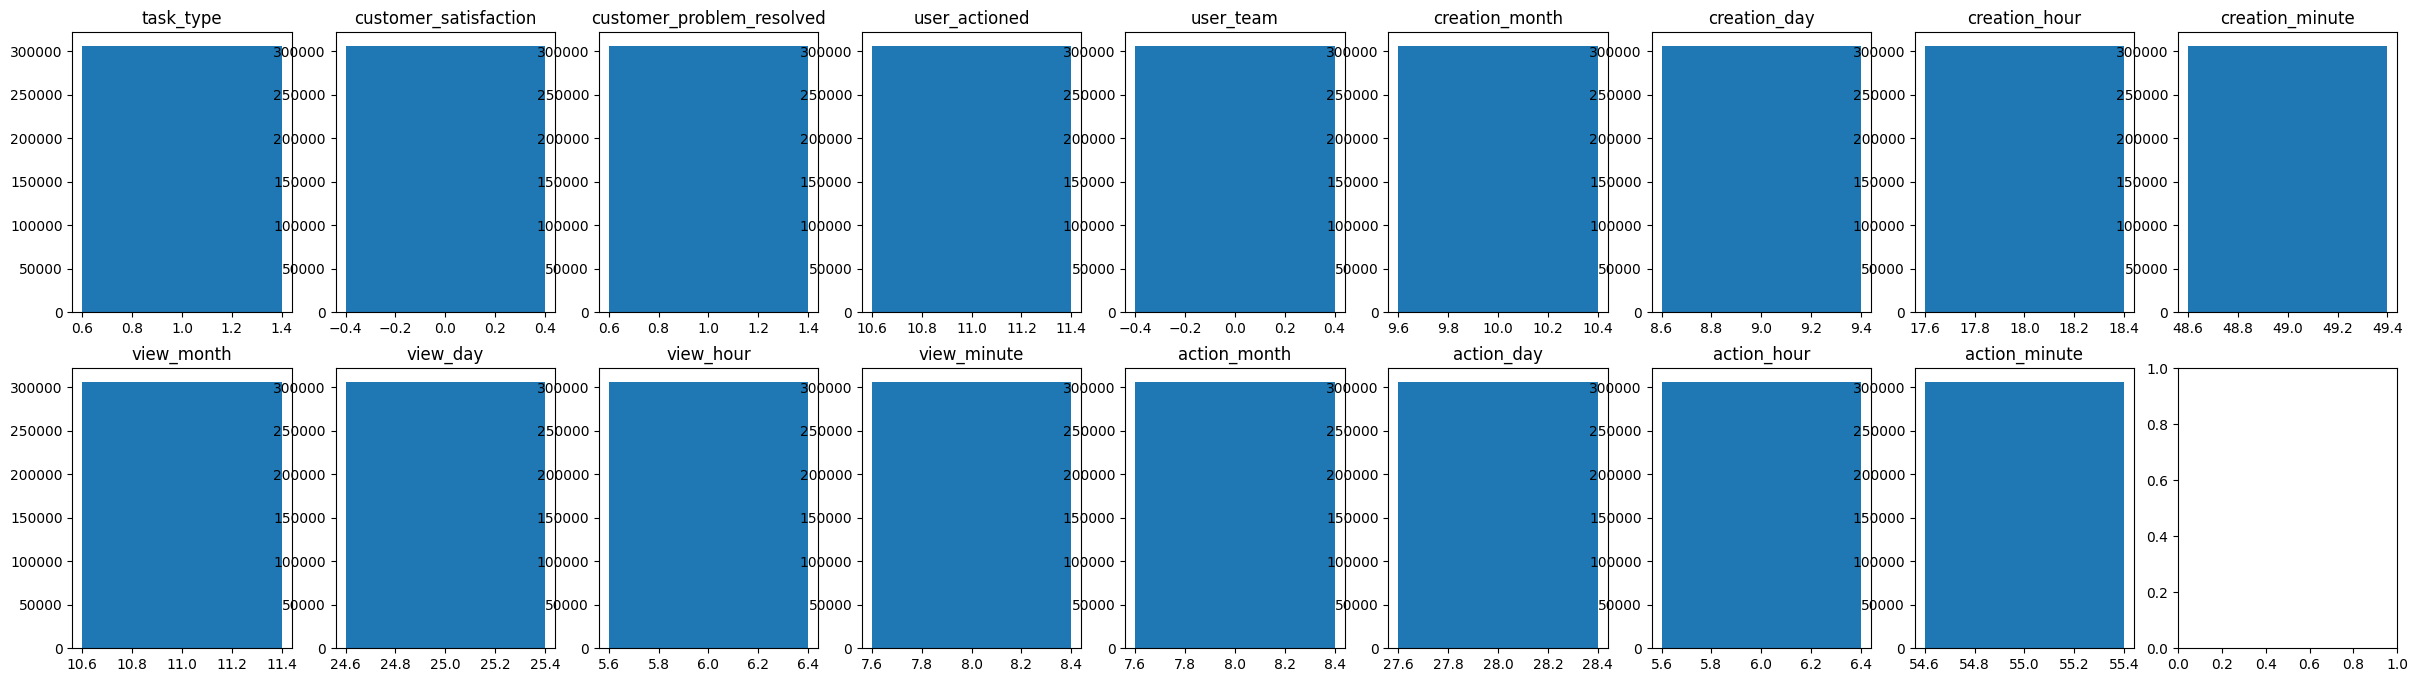

KL Divergence: 283.51247034425336


In [27]:
# numpy_result = np.array(result_df)
H_l = Helper(GAN_M_df)
cols = H_l.plot_data('/kaggle/working/GAN_softmax.png')
kl_divergence = compute_kl_divergence(data_org, GAN_M_df)
print(f"KL Divergence: {kl_divergence}")

<a name='3-4'></a>
**Cosine similarity**

In [18]:
batch_size = 1000  # Adjust this based on your available memory
num_samples = data_org.shape[0]

# Initialize an empty list to store batch similarity scores
batch_similarity_scores = []

for i in range(0, num_samples, batch_size):
    end_idx = min(i + batch_size, num_samples)
    batch_original = data_org[i:end_idx]
    batch_synthesized = GAN_M_df[i:end_idx]

    # Calculate cosine similarity for the batch
    batch_cosine_sim = cosine_similarity(batch_original, batch_synthesized)

    # Append the mean similarity score for the batch to the list
    batch_similarity_scores.append(np.mean(batch_cosine_sim))

# Calculate the overall mean cosine similarity score
mean_cosine_similarity = np.mean(batch_similarity_scores)

print(f"Mean Cosine Similarity Score: {mean_cosine_similarity}")

Mean Cosine Similarity Score: 0.8206581290967028


<a name='4'></a>
## 3 - VAE_sigmoid

<a name='4-1'></a>
**Class of VAE_sigmoid**

In [19]:
# Define the VAE model
class VAE(keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.mu = 0
        self.std = 0

    def build_encoder(self):
        inputs = keras.Input(shape=(17,))
        x = layers.Dense(8192, activation='LeakyReLU')(inputs)
        x = layers.Dense(4096, activation='relu')(x)
        x = layers.Dense(2048, activation='LeakyReLU')(x)
        x = layers.Dense(1024, activation='relu')(x)
        x = layers.Dense(512, activation='LeakyReLU')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(256, activation='relu')(x)
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        self.mu = z_mean
        self.std = z_log_var
        return keras.Model(inputs, [z_mean, z_log_var])

    def build_decoder(self):
        latent_inputs = keras.Input(shape=(self.latent_dim,))
        x = layers.Dense(256, activation='relu')(latent_inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(512, activation='LeakyReLU')(x)
        x = layers.Dense(1024, activation='relu')(x)
        x = layers.Dense(2048, activation='LeakyReLU')(x)
        x = layers.Dense(4096, activation='relu')(x)
        x = layers.Dense(8192, activation='LeakyReLU')(x)
        outputs = layers.Dense(17, activation='sigmoid')(x)
        return keras.Model(latent_inputs, outputs)

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling((z_mean, z_log_var))
        reconstructed = self.decoder(z)
        return reconstructed
    def Predicto(self,num_samples):
#         z_mean, z_log_var = vae.encoder(data)
        epsilon = np.random.normal(0, 1, size=(num_samples, latent_dim))
        synthetic_samples = self.mu + np.exp(0.5 * self.std) * epsilon
        # Pass 'synthetic_samples' through the decoder to get the generated data
        generated_data = vae.decoder.predict(synthetic_samples)
        final = np.zeros((num_samples,17))
        for i in range(17):
            final[:,i] = generated_data[:,i]/th_out[i]
            final = np.round(final).astype(int)
        return final
    def plot_dist(self, num_samples, feature_names, save_path=None):
        final = self.Predicto(num_samples)
    
        # Calculate the number of rows and columns for the subplots
        num_rows = 2
        num_cols = 9
    
    # Create subplots
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 8))
    
    # Flatten the axes array for easier indexing
        axes = axes.flatten()
    
        for i in range(min(self.num_features, num_rows * num_cols)):
            unique_values, value_counts = np.unique(final[:, i], return_counts=True)
            axes[i].bar(unique_values, value_counts)
            axes[i].set_title(f'{feature_names[i]}')  # Use feature names as titles for each subplot

        # Adjust layout to prevent clipping of titles
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)

        plt.show()

# Define the loss function for VAE
def vae_loss(y_true, y_pred):
    z_mean, z_log_var = vae.encoder(y_true)
    reconstruction_loss = keras.losses.binary_crossentropy(y_true, y_pred)
    reconstruction_loss *= 34  # Update this based on the correct size of your input data
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)
def beta_divergence(y_true, y_pred, beta=1):
    z_mean, z_log_var = vae.encoder(y_true)
    
    # Reconstruction loss
    reconstruction_loss = keras.losses.binary_crossentropy(y_true, y_pred)
    reconstruction_loss *= 34  # Update this based on the correct size of your input data
    
    # KL divergence (beta divergence with beta=1)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    # Beta divergence term
    beta_loss = reconstruction_loss + beta * kl_loss
    
    return K.mean(beta_loss)

latent_dim = 150
vae = VAE(latent_dim)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001,clipvalue=5.0), loss=lambda y_true, y_pred: beta_divergence(y_true, y_pred, beta=1))
vae.fit(Sigmoid_data, Sigmoid_data, epochs=30, batch_size=2048)


Epoch 1/30
150/150 [==============================] - 42s 230ms/step - loss: 26.7086
Epoch 2/30
150/150 [==============================] - 35s 230ms/step - loss: 26.7650
Epoch 3/30
150/150 [==============================] - 35s 229ms/step - loss: 15.8277
Epoch 4/30
150/150 [==============================] - 35s 229ms/step - loss: 99.4109
Epoch 5/30
150/150 [==============================] - 35s 229ms/step - loss: 18.7131
Epoch 6/30
150/150 [==============================] - 35s 230ms/step - loss: 18.3555
Epoch 7/30
150/150 [==============================] - 35s 229ms/step - loss: 17.8011
Epoch 8/30
150/150 [==============================] - 35s 230ms/step - loss: 18.8582
Epoch 9/30
150/150 [==============================] - 35s 229ms/step - loss: 19.5838
Epoch 10/30
150/150 [==============================] - 35s 229ms/step - loss: 19.8674
Epoch 11/30
150/150 [==============================] - 35s 230ms/step - loss: 19.5220
Epoch 12/30
150/150 [==============================] - 35s 229m

<a name='4-2'></a>
**Data plot**


9576/9576 [==============================] - 13s 1ms/step


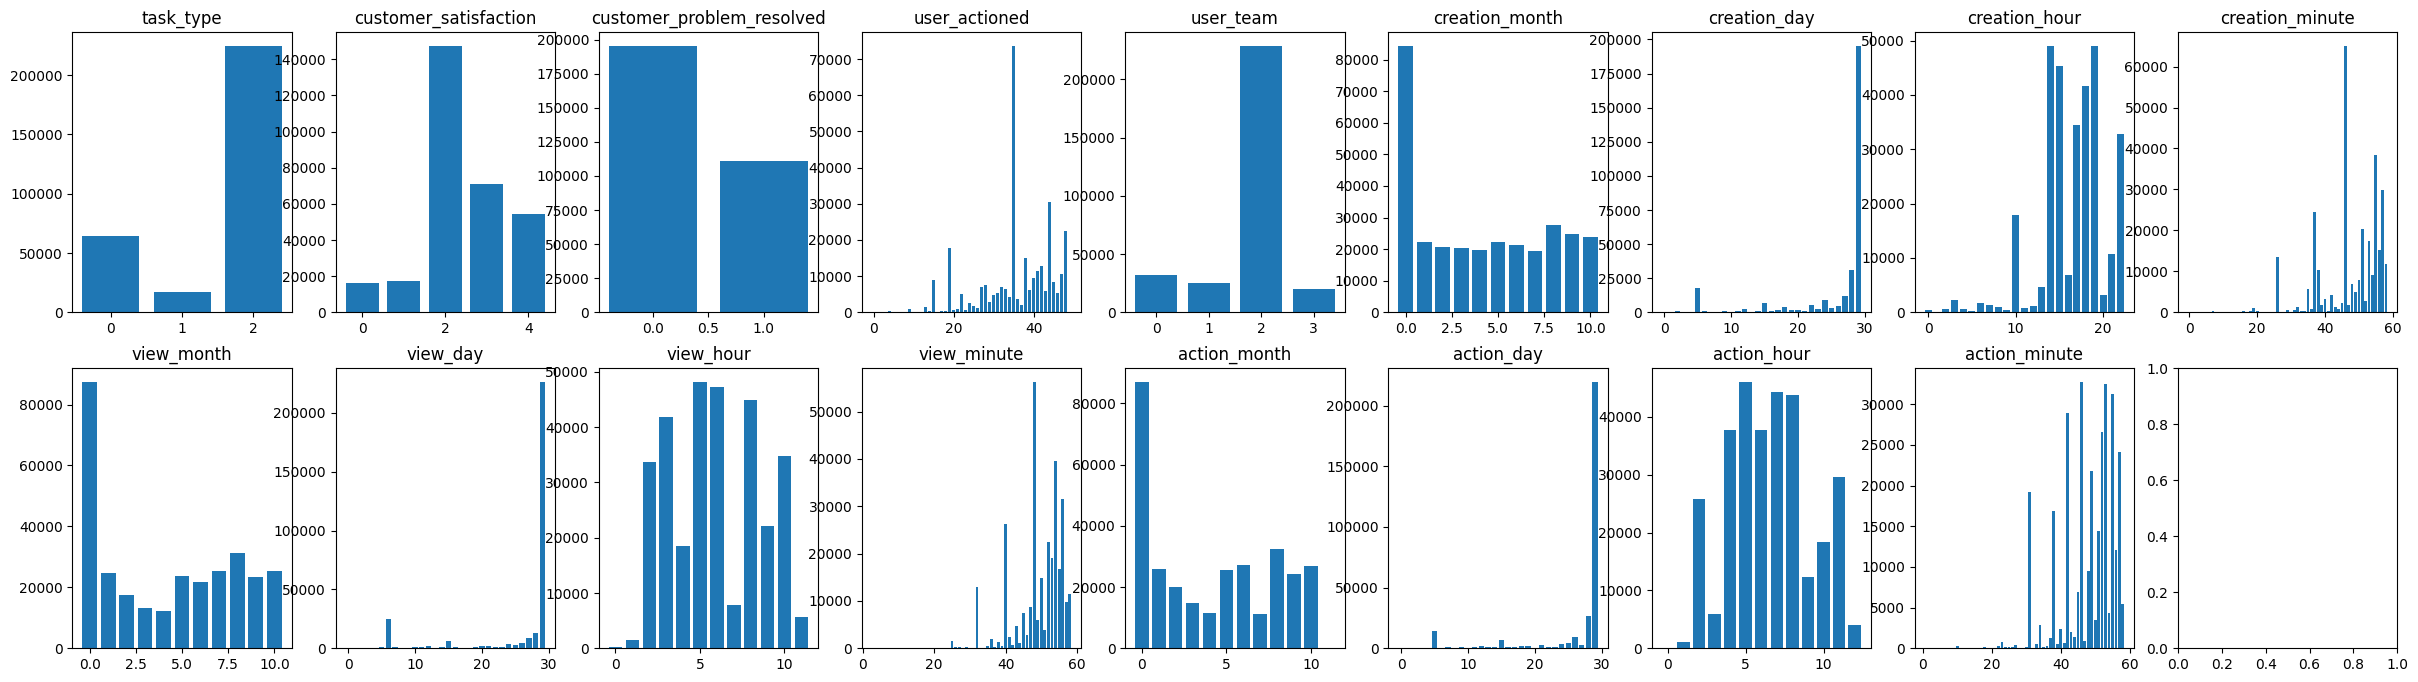

KL Divergence: 29.130940482535912


In [28]:
output = vae.Predicto(306419)
VAE_S_df = pd.DataFrame(output, columns=cols)
H_VAE = Helper(VAE_S_df)
vae.decoder.save(f'/kaggle/working/VAE_sigmoid.h5')
H_VAE.plot_data('/kaggle/working/VAE_sigmoid.png')
kl_divergence = compute_kl_divergence(data_org, VAE_S_df)
print(f"KL Divergence: {kl_divergence}")

<a name='4-3'></a>
**Cosine similarity**

In [21]:
batch_size = 1000  # Adjust this based on your available memory
num_samples = data_org.shape[0]

# Initialize an empty list to store batch similarity scores
batch_similarity_scores = []

for i in range(0, num_samples, batch_size):
    end_idx = min(i + batch_size, num_samples)
    batch_original = data_org[i:end_idx]
    batch_synthesized = VAE_S_df[i:end_idx]

    # Calculate cosine similarity for the batch
    batch_cosine_sim = cosine_similarity(batch_original, batch_synthesized)

    # Append the mean similarity score for the batch to the list
    batch_similarity_scores.append(np.mean(batch_cosine_sim))

# Calculate the overall mean cosine similarity score
mean_cosine_similarity = np.mean(batch_similarity_scores)

print(f"Mean Cosine Similarity Score: {mean_cosine_similarity}")

Mean Cosine Similarity Score: 0.9218608915332203


<a name='5'></a>
## 4- GAN_softmax


<a name='5-1'></a>
**Class of VAE_Softmax**

In [67]:
# Define the VAE model
class VAE(keras.Model):
    def __init__(self, latent_dim,d_shape):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.data_shape = d_shape
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.mu = 0
        self.std = 0

    def build_encoder(self):
        inputs = keras.Input(shape=(self.data_shape,))
        x = layers.Dense(8192, activation='LeakyReLU')(inputs)
        x = layers.Dense(4096, activation='relu')(x)
        x = layers.Dense(2048, activation='LeakyReLU')(x)
        x = layers.Dense(1024, activation='relu')(x)
        x = layers.Dense(512, activation='LeakyReLU')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(256, activation='relu')(x)
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        self.mu = z_mean
        self.std = z_log_var
        return keras.Model(inputs, [z_mean, z_log_var])

    def build_decoder(self):
        latent_inputs = keras.Input(shape=(self.latent_dim,))
        x = layers.Dense(256, activation='relu')(latent_inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(512, activation='LeakyReLU')(x)
        x = layers.Dense(1024, activation='relu')(x)
        x = layers.Dense(2048, activation='LeakyReLU')(x)
        x = layers.Dense(4096, activation='relu')(x)
        x = layers.Dense(8192, activation='LeakyReLU')(x)
        outputs = layers.Dense(self.data_shape, activation='softmax')(x)
        return keras.Model(latent_inputs, outputs)

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling((z_mean, z_log_var))
        reconstructed = self.decoder(z)
        return reconstructed
    def Predicto(self,num_samples):
        epsilon = np.random.normal(0, 1, size=(num_samples, latent_dim))
        synthetic_samples = self.mu + np.exp(0.5 * self.std) * epsilon
        # Pass 'synthetic_samples' through the decoder to get the generated data
        generated_data = self.decoder.predict(synthetic_samples)
        predicted_classes = tf.argmax(generated_data, axis=1)
        output_column_name = 'output'  # Replace with your desired column name
        generated_df = pd.DataFrame({output_column_name: predicted_classes.numpy()})
        return generated_df
    def plot_dist(self, num_samples, feature_names, save_path=None):
        final = self.Predicto(num_samples)
    
        # Calculate the number of rows and columns for the subplots
        num_rows = 2
        num_cols = 9
    
    # Create subplots
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 8))
    
    # Flatten the axes array for easier indexing
        axes = axes.flatten()
    
        for i in range(min(self.num_features, num_rows * num_cols)):
            unique_values, value_counts = np.unique(final[:, i], return_counts=True)
            axes[i].bar(unique_values, value_counts)
            axes[i].set_title(f'{feature_names[i]}')  # Use feature names as titles for each subplot

        # Adjust layout to prevent clipping of titles
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)

        plt.show()

# Define the loss function for VAE
def beta_divergence(y_true, y_pred, beta=1):
    z_mean, z_log_var = vae2.encoder(y_true)
    
    # Reconstruction loss
    reconstruction_loss = keras.losses.binary_crossentropy(y_true, y_pred)
    reconstruction_loss *= 34  # Update this based on the correct size of your input data
    
    # KL divergence (beta divergence with beta=1)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    # Beta divergence term
    beta_loss = reconstruction_loss + beta * kl_loss
    
    return K.mean(beta_loss)

<a name='5-2'></a>
**Training**


In [68]:
latent_dim = 150
result_dfs = []  # List to collect DataFrames
for i in range(len(encoded)):
    enc_data = encoded[i]  # Assuming encoded[i] is a NumPy array or TensorFlow tensor
    vae2 = VAE(latent_dim,enc_data.shape[1])
    vae2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001,clipvalue=5.0), loss=lambda y_true, y_pred: beta_divergence(y_true, y_pred, beta=1))
    vae2.fit(enc_data, enc_data, epochs=10, batch_size=2048)
    vae2.decoder.save(f'/kaggle/working/VAE_softmax_{i}.h5')
    synthetic_data = vae2.Predicto(306419)
    # Append synthetic data DataFrame to the list
    result_dfs.append(synthetic_data)

# Concatenate all DataFrames in the list
VAE_M_df = pd.concat(result_dfs, axis=1)

# Reset the index of the final DataFrame
VAE_M_df.reset_index(drop=True, inplace=True)
VAE_M_df.columns = cols

Epoch 1/10
150/150 [==============================] - 40s 228ms/step - loss: 1.9545
Epoch 2/10
150/150 [==============================] - 34s 228ms/step - loss: 23.0049
Epoch 3/10
150/150 [==============================] - 34s 227ms/step - loss: 14.1086
Epoch 4/10
150/150 [==============================] - 34s 227ms/step - loss: 247179164256455132575803899904.0000
Epoch 5/10
150/150 [==============================] - 34s 227ms/step - loss: 6.2332
Epoch 6/10
150/150 [==============================] - 34s 227ms/step - loss: 113.2715
Epoch 7/10
150/150 [==============================] - 34s 227ms/step - loss: 6.1733
Epoch 8/10
150/150 [==============================] - 34s 227ms/step - loss: 6.2923
Epoch 9/10
150/150 [==============================] - 34s 227ms/step - loss: 6.1121
Epoch 10/10
9576/9576 [==============================] - 13s 1ms/step
Epoch 1/10
150/150 [==============================] - 40s 227ms/step - loss: 13.2063
Epoch 2/10
150/150 [==============================] - 34

<a name='5-3'></a>
**Data plot**


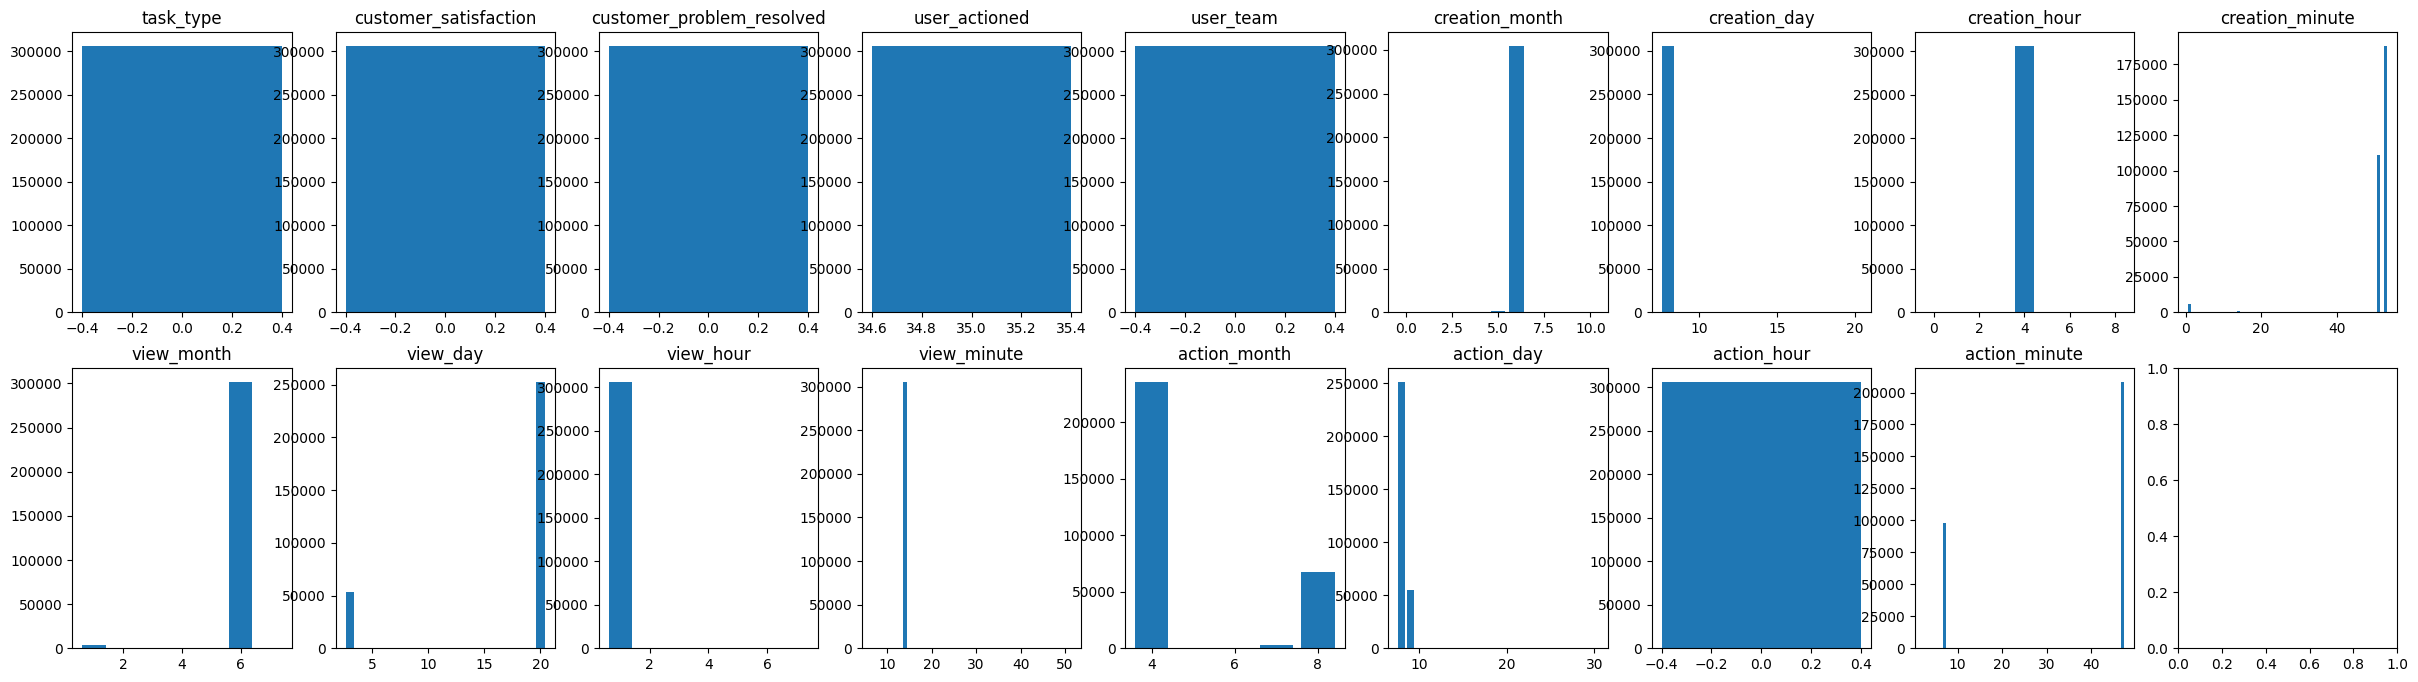

KL Divergence: 286.16860198424797


In [69]:
H_VAE = Helper(VAE_M_df)
H_VAE.plot_data('/kaggle/working/VAE_softmax.png')
kl_divergence = compute_kl_divergence(data_org, VAE_M_df)
print(f"KL Divergence: {kl_divergence}")

<a name='5-4'></a>
**Cosine similarity**

In [70]:
batch_size = 1000  # Adjust this based on your available memory
num_samples = data_org.shape[0]

# Initialize an empty list to store batch similarity scores
batch_similarity_scores = []

for i in range(0, num_samples, batch_size):
    end_idx = min(i + batch_size, num_samples)
    batch_original = data_org[i:end_idx]
    batch_synthesized = VAE_M_df[i:end_idx]

    # Calculate cosine similarity for the batch
    batch_cosine_sim = cosine_similarity(batch_original, batch_synthesized)

    # Append the mean similarity score for the batch to the list
    batch_similarity_scores.append(np.mean(batch_cosine_sim))

# Calculate the overall mean cosine similarity score

mean_cosine_similarity = np.mean(batch_similarity_scores)

print(f"Mean Cosine Similarity Score: {mean_cosine_similarity}")

Mean Cosine Similarity Score: 0.7707384478014092
